In [1]:
import pandas as pd
import numpy as np
import os

## loading file names and making metadata for data files

In [2]:
input_folder = 'data/'
file_names = os.listdir(input_folder)
print(file_names)

['005es16732_MS___1_MoTuWeThFr_2015-01-01_2015-12-31.xlsx', '520es00972_MW___3_MoTuWeThFr_2015-01-01_2015-12-31.xlsx']


In [3]:
def define_route(route):
    if route=='005':
        return'I5'
    elif route=='090':
        return 'I90'
    elif route == '520':
        return '520'
    else:
        return None

def get_milepost(string):
    a = float(string[:-2])
    b = float(string[-2:])/100
    return a+b
        
def get_metadata(file_name):
    name = file_name.split('_')
    route, milepost, lane, weekend, start, end = define_route(name[0][:3]), name[0][-5:], name[4], name[5], name[6], name[7]
    if route is None:
        print('unknown route for '+file_name)
    return route, get_milepost(milepost), lane, weekend, start, end
    

In [4]:
# get data files info
# 520es00972_MW___3_MoTuWeThFr_2015-01-01_2015-12-31.csv :
#        (Route 520, milepost 9.72, general purpose lane, mainline, westbound, shared thru,
#         mainline, not speed loop/speed trap/meter rate, lane 3, Monday through Friday in 2015)

# I don't understand lane details (general purpose lane, mainline, westbound, shared thru, mainline, not speed loop/speed trap/meter rate)
info = {'id':[], 'file_name':[], 'route':[], 'milepost':[], 'lane':[], 'weekend':[], 'start_date':[], 'end_date':[] } 

for i, name in enumerate(file_names):
    name = name[:-5]  # remove '.xlsx' part
    route, milepost, lane, weekend, start, end = get_metadata(name) 
    info['id'].append(i)
    info['file_name'].append(name) 
    info['route'].append(route) 
    info['milepost'].append(milepost)
    info['lane'].append(lane)
    info['start_date'].append(start)
    info['end_date'].append(end)  
    if weekend == 'MoTuWeThFr':
        info['weekend'].append(False)
    else:
        info['weekend'].append(True)
    
metadata = pd.DataFrame(data=info)
metadata.start_date = pd.to_datetime(metadata.start_date)
metadata.end_date = pd.to_datetime(metadata.end_date)
metadata

,id,file_name,route,milepost,lane,weekend,start_date,end_date
0,0,005es16732_MS___1_MoTuWeThFr_2015-01-01_2015-1...,I5,167.32,1,False,2015-01-01,2015-12-31
1,1,520es00972_MW___3_MoTuWeThFr_2015-01-01_2015-1...,520,9.72,3,False,2015-01-01,2015-12-31


## loading dataframes

In [5]:
speed, VpLpH, occupancy = [], [], []
for name in file_names:
    name = input_folder+name
    speed.append(pd.read_excel(name, sheet_name='Speed', index_col=0))
    VpLpH.append(pd.read_excel(name, sheet_name='Volume Per Lane', index_col=0))    
    occupancy.append(pd.read_excel(name, sheet_name='Occupancy', index_col=0))    

/Users/stlp/opt/anaconda3/lib/python3.9/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/Users/stlp/opt/anaconda3/lib/python3.9/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/Users/stlp/opt/anaconda3/lib/python3.9/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/Users/stlp/opt/anaconda3/lib/python3.9/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/Users/stlp/opt/anaconda3/lib/python3.9/site-packages/openpyxl/s

In [145]:
def calc_density(speed, volume_passed, time_minutes):
    headway = time/int(volume_passed) 
    spacing = headway * int(speed)/60
    return 1/spacing

In [8]:
s = speed[0]
vpl = VpLpH[0]
occ = occupancy[0]
aggregated = {'time':[], 'date':[], 'speed':[], 'occupancy':[], 'volumePL':[], 'density':[]}

for time in s.index:
    for date in s.columns[1:]:
        velocity, volume = s.loc[time, date], vpl.loc[time, date]
        aggregated['time'].append(time)
        aggregated['date'].append(date)
        aggregated['speed'].append(velocity)
        aggregated['occupancy'].append(occ.loc[time, date])
        aggregated['volumePL'].append(volume)
        aggregated['density'].append(volume/velocity)

data = pd.DataFrame(data=aggregated)
# data.set_index(['time', 'date'], inplace=True)
data['date'] = pd.to_datetime(data.date)
data['time'] = pd.to_datetime(data.time).dt.time
data

,time,date,speed,occupancy,volumePL,density
0,00:00:00,2015-01-02,66.818,0.0052,120,1.795923
1,00:00:00,2015-01-05,54.701,0.0030,60,1.096872
2,00:00:00,2015-01-06,60.891,0.0048,120,1.970735
3,00:00:00,2015-01-07,60.512,0.0038,96,1.586462
4,00:00:00,2015-01-08,61.720,0.0065,144,2.333117
...,...,...,...,...,...,...
74875,23:55:00,2015-12-25,73.760,0.0088,204,2.765727
74876,23:55:00,2015-12-28,67.614,0.0061,144,2.129736
74877,23:55:00,2015-12-29,71.711,0.0070,168,2.342737
74878,23:55:00,2015-12-30,63.551,0.0056,120,1.888247


<Axes: xlabel='density', ylabel='volumePL'>

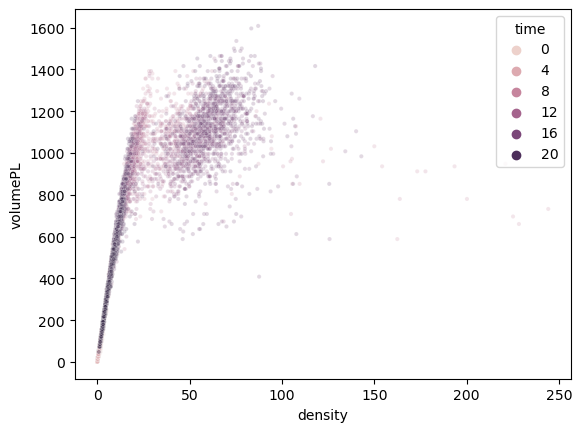

In [14]:
import seaborn as sns
# sns.scatterplot(data=data[data.date == '2015-01-02'], x='occupancy', y='speed', alpha=0.1)
sns.scatterplot(data=data[data.date.apply(lambda d:d.month) == 4], x='density', y='volumePL', alpha=0.2, hue=data.time.apply(lambda t:t.hour), marker='.')
# sns.scatterplot(data=data, x='density', y='volumePL', alpha=0.2, hue=data.date.apply(lambda d:d.month), marker='.')



In [ ]:
def get_FD(route, milepost):
    # aggregate different lanes of the nearest post
    return None

## interaction with logic